In [2]:
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------

**Before Integration.ipynb code testing**

In [ ]:
import os
import cv2
import dlib
import json
import shutil
import numpy as np
import mediapipe as mp
import tensorflow as tf

from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add, ReLU, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [3]:
print(tf.__version__)
# layers = tf.keras.layers
# models = tf.keras.models
# Adam = tf.keras.optimizers.Adam

2.18.0


In [13]:
# Define paths
base_dir = r'D:\PycharmProjects\pro_dis_2\collected_data\!test'
extracted_frames_dir = r'D:\PycharmProjects\pro_dis_2\collected_data\!test\extracted_frames_one'
cropped_frames_dir = r'D:\PycharmProjects\pro_dis_2\collected_data\!test\cropped_frames_two'

In [12]:
def extract_frame(frame, output_dir, frame_index):
    frame_filename = os.path.join(output_dir, f"{frame_index:02d}.png")  # Format frame index with leading zeros
    cv2.imwrite(frame_filename, frame)
    return frame_filename

def extract_frames_with_priority_deletion(video_path, output_dir, target_frames=60):
    # Create base directory for storing extracted frames
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    # Handle case when the video has fewer than the target number of frames
    if total_frames < target_frames:
        for i in range(total_frames):
            extract_frame(frames[i], output_dir, i + 1)  # Start frame index from 1

        # Copy the last frame to fill the deficit until the target number is reached
        last_frame = frames[-1]
        for i in range(total_frames, target_frames):
            extract_frame(last_frame, output_dir, i + 1)

        print(f"Copied last frame to fill the deficit for {video_path}.")
        cap.release()
        return

    # Handle case when the video has more than the target number of frames
    if total_frames > target_frames:
        frames_to_delete = total_frames - target_frames
        delete_from_end = int(frames_to_delete * 0.5)  # 50% of frames to delete from the end
        delete_from_start = frames_to_delete - delete_from_end  # 20% from the start

        # Retain the middle portion after deleting the required frames
        frames = frames[delete_from_start:total_frames - delete_from_end]

    # Extract frames after deletion logic or for target-sized videos
    for i in range(len(frames)):
        extract_frame(frames[i], output_dir, i + 1)

    cap.release()
    print(f"Extracted {len(frames)} frames from {video_path} into {output_dir}")

for video_file in os.listdir(base_dir):
    if video_file.endswith('.mp4'):
        video_path = os.path.join(base_dir, video_file)
        print(f"Processing video: {video_file}")
        extract_frames_with_priority_deletion(video_path, extracted_frames_dir, target_frames=60)

print("\nFrame extraction completed.")


Frame extraction completed.


In [13]:
# Load the detector and predictor (dlib models)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("D:/PycharmProjects/pro_dis_2/models/shape_predictor_68_face_landmarks.dat")

# Mouth crop dimensions
LIP_HEIGHT = 80
LIP_WIDTH = 112

def process_frame(frame_file, path, output_path):
    """
    Save a single frame as a .png image in the specified directory.
    Ensures complete image save before moving to the next frame.
    """
    frame_path = os.path.join(path, frame_file)
    try:
        # Load the frame
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Could not read frame {frame_path}. Skipping.")
            return False

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale image
        faces = detector(gray)

        if not faces:
            return False

        # Only process if a face is detected
        for face in faces:
            landmarks = predictor(gray, face)

            # Extract the mouth region by iterating over the landmarks (48 to 67)
            mouth_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)]
            mouth_points_np = np.array(mouth_points)

            # Find the bounding rectangle around the mouth points
            x, y, w, h = cv2.boundingRect(mouth_points_np)

            # Calculate padding to fit the target dimensions
            width_diff = LIP_WIDTH - w
            height_diff = LIP_HEIGHT - h
            pad_left = max(width_diff // 2, 0)
            pad_right = max(width_diff - pad_left, 0)
            pad_top = max(height_diff // 2, 0)
            pad_bottom = max(height_diff - pad_top, 0)

            # Adjust padding to ensure it doesn’t exceed image boundaries
            pad_left = min(pad_left, x)
            pad_right = min(pad_right, frame.shape[1] - (x + w))
            pad_top = min(pad_top, y)
            pad_bottom = min(pad_bottom, frame.shape[0] - (y + h))

            # Crop and resize the mouth region
            lip_frame = frame[y - pad_top:y + h + pad_bottom, x - pad_left:x + w + pad_right]
            lip_frame = cv2.resize(lip_frame, (LIP_WIDTH, LIP_HEIGHT))

            # Save the cropped mouth region to the output directory
            output_frame_path = os.path.join(output_path, frame_file)
            cv2.imwrite(output_frame_path, lip_frame)

            return True  # Exit after processing the first detected face
    except Exception as e:
        print(f"Error processing frame {frame_path}: {e}")
        return False

# Create the output directory if it doesn't exist
os.makedirs(cropped_frames_dir, exist_ok=True)

# Get all frame files in the extracted frames directory
frame_files = [f for f in os.listdir(extracted_frames_dir) if f.endswith('.png')]
cropped_count = 0  # Counter for successfully cropped frames

# Process each frame file
for frame_file in frame_files:
    if process_frame(frame_file, extracted_frames_dir, cropped_frames_dir):
        cropped_count += 1

# Print the number of cropped images
print(f"Finished processing all frames. Images cropped -> {cropped_count}")

print("\nMouth cropping completed for all frames.")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\PycharmProjects\\pro_dis_2\\collected_data\\!test\\extracted_frames_one'

In [53]:
def combine_images(input_path, output_path, output_filename="combined_frames.png"):
    # List all frame files and sort them to maintain order
    frame_files = [f for f in os.listdir(input_path) if f.endswith('.png')]
    frame_files.sort()  # Ensure the frames are in order

    # Check that there are exactly 60 frames
    if len(frame_files) != 60:
        print(f"Warning: {input_path} does not contain exactly 60 frames. Skipping.")
        return

    # Load the first image to get dimensions
    first_image = cv2.imread(os.path.join(input_path, frame_files[0]))
    if first_image is None:
        print(f"Error: Could not read {frame_files[0]}.")
        return

    img_height, img_width, channels = first_image.shape

    # Create an empty array for the combined image (10 rows × 6 columns)
    combined_image = np.zeros((img_height * 10, img_width * 6, channels), dtype=np.uint8)

    # Place each frame into the correct position in the combined image
    for idx, frame_file in enumerate(frame_files):
        img = cv2.imread(os.path.join(input_path, frame_file))
        if img is None:
            print(f"Error: Could not read {frame_file}.")
            continue

        row = idx // 6
        col = idx % 6

        # Place the image in the combined image array
        combined_image[row * img_height:(row + 1) * img_height, col * img_width:(col + 1) * img_width] = img

    # Save the combined image
    cv2.imwrite(os.path.join(output_path, output_filename), combined_image)

    print(f"Combined image saved at: {os.path.join(output_path, output_filename)}")

# Create the output directory if it does not exist
os.makedirs(base_dir, exist_ok=True)

# Combine the images and save as a single image
combine_images(cropped_frames_dir, base_dir)

print("\nAll frames are combined and saved as a single image.")

Combined image saved at: D:\PycharmProjects\pro_dis_2\collected_data\!test\combined_frames.png

All frames are combined and saved as a single image.


**(one-time)**

In [21]:
train_path = r'D:\PycharmProjects\pro_dis_2\collected_data\8_final_images_800_cl8\Train'
test_path = r'D:\PycharmProjects\pro_dis_2\collected_data\8_final_images_800_cl8\Test'
valid_path = r'D:\PycharmProjects\pro_dis_2\collected_data\8_final_images_800_cl8\Validation'

In [22]:
# IDG = ImageDataGenerator(rescale = 1/255)
#
# # word_classes = ['bat', 'cup', 'dog', 'drop', 'eat', 'fast', 'fish', 'hot', 'jump', 'milk', 'pen', 'red', 'stop', 'win', 'yes']
#
# word_classes = ['bat', 'cup', 'drop', 'eat', 'fish', 'hot', 'jump', 'milk']

In [23]:
# test = IDG.flow_from_directory(directory=test_path, target_size=(224, 224),
#                                classes=word_classes, batch_size=10,
#                                class_mode='categorical')
#
# train = IDG.flow_from_directory(directory=train_path, target_size=(224, 224),
#                                 classes=word_classes, batch_size=10,
#                                 class_mode='categorical')
#
# valid = IDG.flow_from_directory(directory=valid_path, target_size=(224, 224),
#                                 classes=word_classes, batch_size=10, shuffle=False,
#                                 class_mode='categorical')

Found 640 images belonging to 8 classes.
Found 5120 images belonging to 8 classes.
Found 640 images belonging to 8 classes.


**testing models**

In [24]:
# new_model = load_model(r'D:\PycharmProjects\pro_dis_2\models\model3264_cl8_d800_1e4.h5')

In [25]:
# # Evaluate the model on the test data generator
# results = new_model.evaluate(test, verbose=1)
#
# # Print the results
# print("Test Loss:", results[0])
# print("Test Accuracy:", results[1])

D:\PycharmProjects\pro_dis_2\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9624 - loss: 0.1398
Test Loss: 0.17101401090621948
Test Accuracy: 0.948437511920929


**(one-time)**

In [9]:
# # Save the class mapping from the train generator
# class_indices = train.class_indices  # Assuming 'train' is your data generator
# class_labels = {v: k for k, v in class_indices.items()}  # Reverse the mapping
# with open(r'D:\PycharmProjects\pro_dis_2\models\class_labels_cl8.json', 'w') as f:
#     json.dump(class_labels, f)

In [54]:
# # Load the model from the .h5 file
# model = load_model(r'D:\PycharmProjects\pro_dis_2\collected_data\!test\model_3264_4_1e4.h5')

**testing json file**

In [26]:
# # Load the saved class labels
# with open(r'D:\PycharmProjects\pro_dis_2\models\class_labels_cl10.json', 'r') as f:
#     class_labels = json.load(f)

In [27]:
# class_labels

{'0': 'bat',
 '1': 'cup',
 '2': 'drop',
 '3': 'eat',
 '4': 'fish',
 '5': 'hot',
 '6': 'jump',
 '7': 'milk',
 '8': 'pen',
 '9': 'red'}

In [56]:
# # Load the saved class labels
# with open('class_labels.json', 'r') as f:
#     class_labels = json.load(f)
#
# # Load and preprocess the image using PIL
# img_path = r'D:\PycharmProjects\pro_dis_2\collected_data\!test\combined_frames.png'
# img = Image.open(img_path).resize((224, 224), Image.LANCZOS)  # Resize with LANCZOS filter
# img_array = np.array(img) / 255.0  # Normalize pixel values
# img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
#
# # Predict using the loaded model
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions, axis=1)[0]
#
# # Get the predicted class index and label
# print(f"\nPredicted class index: {predicted_class_index}")
# predicted_word = class_labels[str(predicted_class_index)]  # Use string keys for JSON
# print(f"Predicted word: {predicted_word}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predicted class index: 0
Predicted word: cup


In [43]:
# predictions

array([[5.4100692e-05, 5.8469123e-09, 9.5133680e-01, 4.8609152e-02]],
      dtype=float32)

In [57]:
# # Initialize MediaPipe Hands and Drawing modules
# mp_hands = mp.solutions.hands
# mp_drawing = mp.solutions.drawing_utils
#
# # Initialize video capture
# cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
#
# # Set the resolution to the maximum supported by your camera
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)  # Set width (e.g., 1280 for 720p)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)  # Set height (e.g., 720 for 720p)
#
# os.makedirs(base_dir, exist_ok=True)
#
# # Variables to handle recording
# recording = False
# video_writer = None
#
# # Set video codec and file format
# fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30  # Default to 30 if unable to read fps
# frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#
# def is_open_hand(hand_landmarks):
#     """ Check if all fingers are extended (open hand) """
#     for finger_tip, finger_pip in [
#         (mp_hands.HandLandmark.INDEX_FINGER_TIP, mp_hands.HandLandmark.INDEX_FINGER_PIP),
#         (mp_hands.HandLandmark.MIDDLE_FINGER_TIP, mp_hands.HandLandmark.MIDDLE_FINGER_PIP),
#         (mp_hands.HandLandmark.RING_FINGER_TIP, mp_hands.HandLandmark.RING_FINGER_PIP),
#         (mp_hands.HandLandmark.PINKY_TIP, mp_hands.HandLandmark.PINKY_PIP)
#     ]:
#         if hand_landmarks.landmark[finger_tip].y > hand_landmarks.landmark[finger_pip].y:
#             return False  # A finger is not extended
#     return True  # All fingers are extended
#
# def is_closed_fist(hand_landmarks):
#     """ Check if all fingers are folded (closed fist) """
#     for finger_tip, finger_pip in [
#         (mp_hands.HandLandmark.INDEX_FINGER_TIP, mp_hands.HandLandmark.INDEX_FINGER_PIP),
#         (mp_hands.HandLandmark.MIDDLE_FINGER_TIP, mp_hands.HandLandmark.MIDDLE_FINGER_PIP),
#         (mp_hands.HandLandmark.RING_FINGER_TIP, mp_hands.HandLandmark.RING_FINGER_PIP),
#         (mp_hands.HandLandmark.PINKY_TIP, mp_hands.HandLandmark.PINKY_PIP)
#     ]:
#         if hand_landmarks.landmark[finger_tip].y < hand_landmarks.landmark[finger_pip].y:
#             return False  # A finger is extended
#     return True  # All fingers are folded
#
# with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands:
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break
#
#         image_height, image_width, _ = frame.shape
#
#         # Convert BGR to RGB and flip for mirror effect
#         image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         image = cv2.flip(image, 1)
#         image.flags.writeable = False  # Set to False for faster processing
#
#         # Process the image and find hands
#         results = hands.process(image)
#         image.flags.writeable = True  # Set to True for drawing
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#
#         # Check if hands are detected
#         if results.multi_hand_landmarks:
#             for num, hand_landmarks in enumerate(results.multi_hand_landmarks):
#                 mp_drawing.draw_landmarks(
#                     image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
#                     mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
#                     mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
#                 )
#
#                 # Gesture recognition logic
#                 if is_open_hand(hand_landmarks):
#                     cv2.putText(image, "Open Hand Detected", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#                     if not recording:
#                         recording = True
#                         video_name = "recording.mp4"  # Change this if needed for unique names
#                         output_file = os.path.join(base_dir, video_name)
#                         video_writer = cv2.VideoWriter(
#                             output_file,
#                             cv2.VideoWriter_fourcc(*'mp4v'),  # Codec for .mp4 format
#                             fps,
#                             (frame_width, frame_height)
#                         )
#                         if not video_writer.isOpened():
#                             print("Error: Video writer failed to open.")
#                             recording = False
#                         else:
#                             print("Recording started")
#
#                 elif is_closed_fist(hand_landmarks):
#                     cv2.putText(image, "Closed Fist Detected", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
#                     if recording:
#                         recording = False
#                         if video_writer is not None:
#                             video_writer.release()
#                             print(f"Recording stopped and saved at: {output_file}")
#                         video_writer = None  # Reset the writer
#
#         # Write frame to the video if recording
#         if recording and video_writer is not None:
#             video_writer.write(frame)
#
#         # Display the image with results
#         cv2.imshow('Hand Gesture Recognition', image)
#
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break
#
# # Release resources
# cap.release()
# if video_writer is not None:
#     video_writer.release()
# cv2.destroyAllWindows()

Recording started
Recording stopped and saved at: D:\PycharmProjects\pro_dis_2\collected_data\!test\recording.mp4
Recording started
Recording stopped and saved at: D:\PycharmProjects\pro_dis_2\collected_data\!test\recording.mp4
Recording started
Recording stopped and saved at: D:\PycharmProjects\pro_dis_2\collected_data\!test\recording.mp4
Recording started
Recording stopped and saved at: D:\PycharmProjects\pro_dis_2\collected_data\!test\recording.mp4
Recording started
Recording stopped and saved at: D:\PycharmProjects\pro_dis_2\collected_data\!test\recording.mp4


In [1]:
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------

**main lip reading model codes for evaluation**

In [3]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add, ReLU, BatchNormalization, GlobalAveragePooling2D, Dropout

In [4]:
train_path = r'D:\src_4_pro_dis_2\data_4_img_recog\!from asus ssd\7_final_images_130\Train'
test_path = r'D:\src_4_pro_dis_2\data_4_img_recog\!from asus ssd\7_final_images_130\Test'
valid_path = r'D:\src_4_pro_dis_2\data_4_img_recog\!from asus ssd\7_final_images_130\Validation'

In [18]:
IDG = ImageDataGenerator(rescale = 1/255)

word_classes = ['bat', 'cup', 'drop', 'eat', 'fish', 'hot', 'jump', 'milk', 'pen', 'red']

In [19]:
test = IDG.flow_from_directory(directory=test_path, target_size=(224, 224),
                               classes=word_classes, batch_size=16,
                               class_mode='categorical')
train = IDG.flow_from_directory(directory=train_path, target_size=(224, 224),
                                classes=word_classes, batch_size=16,
                                class_mode='categorical')
valid = IDG.flow_from_directory(directory=valid_path, target_size=(224, 224),
                                classes=word_classes, batch_size=16, shuffle=False,
                                class_mode='categorical')

Found 200 images belonging to 10 classes.
Found 900 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D((2, 2), strides=2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2), strides=2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2), strides=2),
    Flatten(),  # Use a reasonable number of neurons
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(10, activation='softmax')
])
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Admin\PycharmProjects\pythonProject_1\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,817,802 (98.49 MB)

 Trainable params: 25,817,802 (98.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # save the model
# model.save(r'C:\Users\c3034339\OneDrive - Sheffield Hallam University\Desktop\Project & Dissertation\8. Saved models\model2811_361_216_d130m.h5')

In [10]:
# train the model
history = model.fit(x=train, validation_data=valid, epochs=15, verbose=2)

Epoch 1/15


C:\Users\Admin\PycharmProjects\pythonProject_1\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 - 28s - 490ms/step - accuracy: 0.1100 - loss: 2.4569 - val_accuracy: 0.2300 - val_loss: 2.1817
Epoch 2/15
57/57 - 22s - 389ms/step - accuracy: 0.3367 - loss: 1.9023 - val_accuracy: 0.4800 - val_loss: 1.5914
Epoch 3/15
57/57 - 22s - 389ms/step - accuracy: 0.5789 - loss: 1.3123 - val_accuracy: 0.6250 - val_loss: 1.1682
Epoch 4/15
57/57 - 24s - 414ms/step - accuracy: 0.7711 - loss: 0.8332 - val_accuracy: 0.7100 - val_loss: 0.9240
Epoch 5/15
57/57 - 22s - 392ms/step - accuracy: 0.8433 - loss: 0.6084 - val_accuracy: 0.8200 - val_loss: 0.6460
Epoch 6/15
57/57 - 22s - 387ms/step - accuracy: 0.9056 - loss: 0.4325 - val_accuracy: 0.8450 - val_loss: 0.5661
Epoch 7/15
57/57 - 22s - 384ms/step - accuracy: 0.9400 - loss: 0.3124 - val_accuracy: 0.8250 - val_loss: 0.5649
Epoch 8/15
57/57 - 22s - 386ms/step - accuracy: 0.9556 - loss: 0.2481 - val_accuracy: 0.9450 - val_loss: 0.2808
Epoch 9/15
57/57 - 22s - 386ms/step - accuracy: 0.9844 - loss: 0.1336 - val_accuracy: 0.9300 - val_loss: 0.2835
Epo

In [34]:
# Evaluate the model on the test data generator
results = model.evaluate(test, verbose=1)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9878 - loss: 0.1093
Test Loss: 0.12276214361190796
Test Accuracy: 0.9850000143051147


In [20]:
# load the model
new_model = load_model(r'D:\src_4_pro_dis_2\8. Saved models\lip detection\model2811_361_21_d130_GOOD.h5')
new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,434,060 (196.21 MB)

 Trainable params: 51,434,058 (196.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
# --------------------------------------------------------------------------------------------------------------
# ---------------------------------Evaluations for Lip Reading model--------------------------------------------
# --------------------------------------------------------------------------------------------------------------

**Accuracy and Learning Curve**

In [11]:
test_loss, test_accuracy = model.evaluate(test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

13/13 - 1s - 115ms/step - accuracy: 0.9900 - loss: 0.0989
Test Accuracy: 99.00%


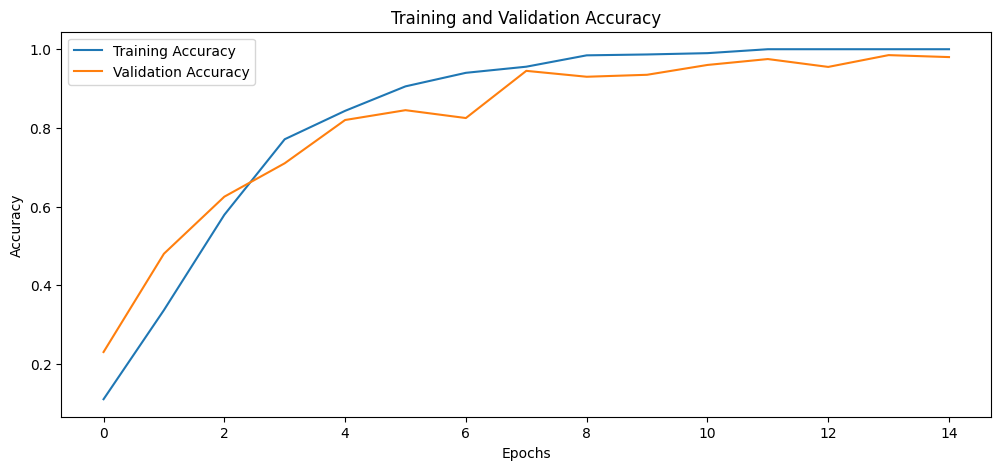

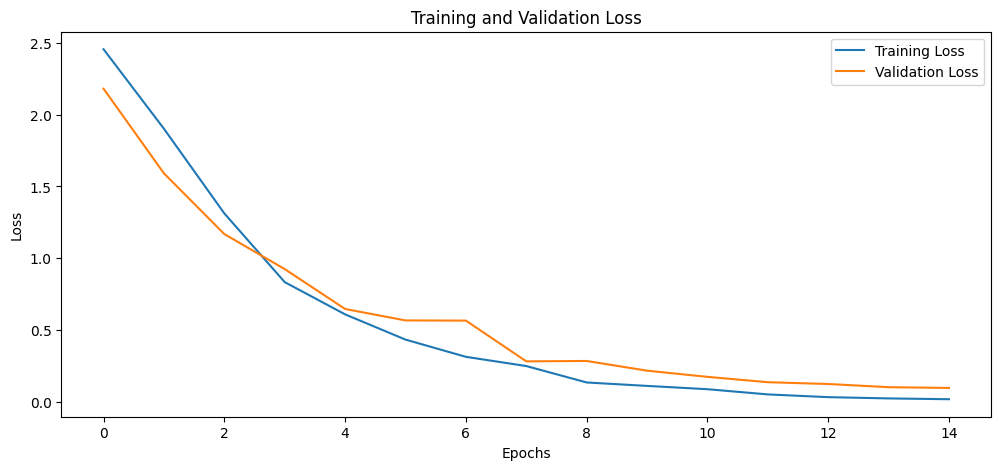

In [12]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Precision, Recall, and F1-Score**

In [27]:
from sklearn.metrics import classification_report
from prettytable import PrettyTable
import numpy as np

# Step 1: Generate Predictions
y_pred_prob = model.predict(test)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Step 2: Get True Labels
y_true = test.classes  # Ground truth labels

# Step 3: Generate Classification Report
report = classification_report(y_true, y_pred, output_dict=True)

# Step 4: Create a PrettyTable
table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]

# Map class indices to word classes
label_dict = {i: word for i, word in enumerate(word_classes)}

# Step 5: Populate the Table
for label, metrics in report.items():
    if label.isdigit():  # Ensure it's a class label
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

# Step 6: Print the Table
print(table)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
+-------+-----------+--------+----------+---------+
| Class | Precision | Recall | F1-Score | Support |
+-------+-----------+--------+----------+---------+
|  bat  |    0.05   |  0.05  |   0.05   |   20.0  |
|  cup  |    0.1    |  0.1   |   0.1    |   20.0  |
|  drop |    0.1    |  0.1   |   0.1    |   20.0  |
|  eat  |    0.14   |  0.15  |   0.15   |   20.0  |
|  fish |    0.15   |  0.15  |   0.15   |   20.0  |
|  hot  |    0.05   |  0.05  |   0.05   |   20.0  |
|  jump |    0.05   |  0.05  |   0.05   |   20.0  |
|  milk |    0.05   |  0.05  |   0.05   |   20.0  |
|  pen  |    0.1    |  0.1   |   0.1    |   20.0  |
|  red  |    0.0    |  0.0   |   0.0    |   20.0  |
+-------+-----------+--------+----------+---------+


**Confusion Matrix**

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


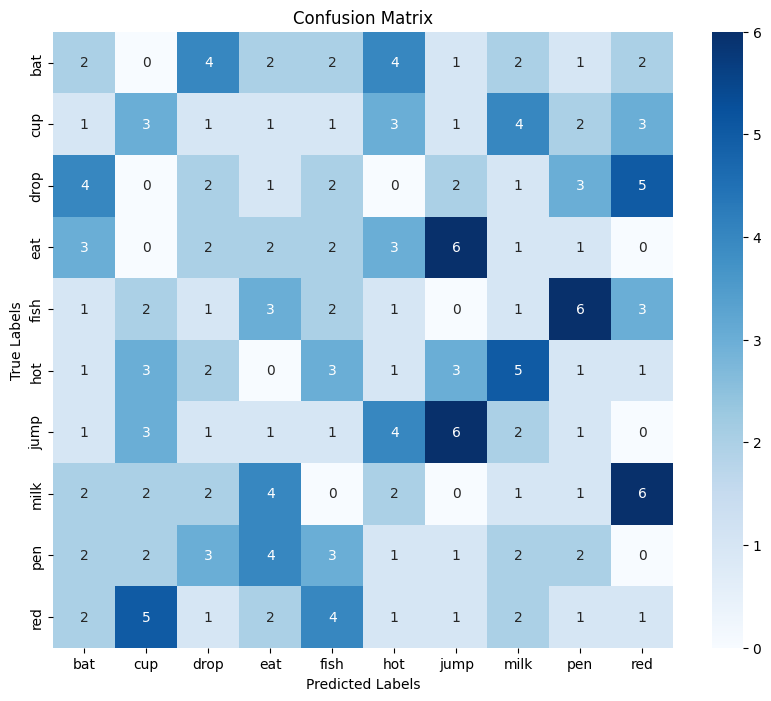

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Make Predictions
y_pred = new_model.predict(test)  # Predict class probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Step 2: Get True Labels
y_true = test.classes  # Ground truth labels from test dataset

# Step 3: Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 4: Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=word_classes, yticklabels=word_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Word Error Rate (WER)**

In [35]:
import numpy as np
from jiwer import wer, compute_measures
from sklearn.preprocessing import LabelEncoder

# Step 1: Load Test Data
# Ensure you have `test` as your test dataset and `word_classes` as your class labels
# Example: word_classes = ['bat', 'cup', 'drop', 'eat', 'fish', 'hot', 'jump', 'milk', 'pen', 'red']

# Step 2: Generate Predictions
y_pred_prob = model.predict(test)  # Predicted probabilities from the model
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to predicted class indices

# Step 3: Convert Predicted Classes to Words
predicted_sequences = [" ".join([word_classes[i] for i in y_pred_classes])]  # Map indices to words

# Step 4: Extract Ground Truth Labels
y_true = test.classes  # True class indices
ground_truth_sequences = [" ".join([word_classes[i] for i in y_true])]  # Map indices to words

# Step 5: Compute Word Error Rate
word_error_rate = wer(ground_truth_sequences, predicted_sequences)
print(f"Word Error Rate (WER): {word_error_rate:.2f}")

# Step 6: Detailed WER Analysis (Optional)
measures = compute_measures(ground_truth_sequences, predicted_sequences)
print(f"Substitutions: {measures['substitutions']}")
print(f"Deletions: {measures['deletions']}")
print(f"Insertions: {measures['insertions']}")
print(f"Word Error Rate (WER): {measures['wer']:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Word Error Rate (WER): 0.86
Substitutions: 168
Deletions: 2
Insertions: 2
Word Error Rate (WER): 0.86


**Per class accuracy**

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score

# Step 1: Predict the Classes
y_pred_prob = model.predict(test)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Step 2: Get True Labels
y_true = test.classes  # Ground truth labels

# Step 3: Initialize Variables for Per-Class Accuracy
class_accuracies = {}
for class_idx, class_name in enumerate(word_classes):
    # Extract indices of samples belonging to the current class
    indices = np.where(y_true == class_idx)[0]

    # Calculate accuracy for the current class
    true_class_labels = y_true[indices]
    predicted_class_labels = y_pred_classes[indices]
    class_accuracy = accuracy_score(true_class_labels, predicted_class_labels)

    # Store the result
    class_accuracies[class_name] = class_accuracy

# Step 4: Display Per-Class Accuracy
for class_name, accuracy in class_accuracies.items():
    print(f"Class '{class_name}' Accuracy: {accuracy * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Class 'bat' Accuracy: 0.00%
Class 'cup' Accuracy: 15.00%
Class 'drop' Accuracy: 15.00%
Class 'eat' Accuracy: 5.00%
Class 'fish' Accuracy: 10.00%
Class 'hot' Accuracy: 0.00%
Class 'jump' Accuracy: 10.00%
Class 'milk' Accuracy: 5.00%
Class 'pen' Accuracy: 10.00%
Class 'red' Accuracy: 10.00%


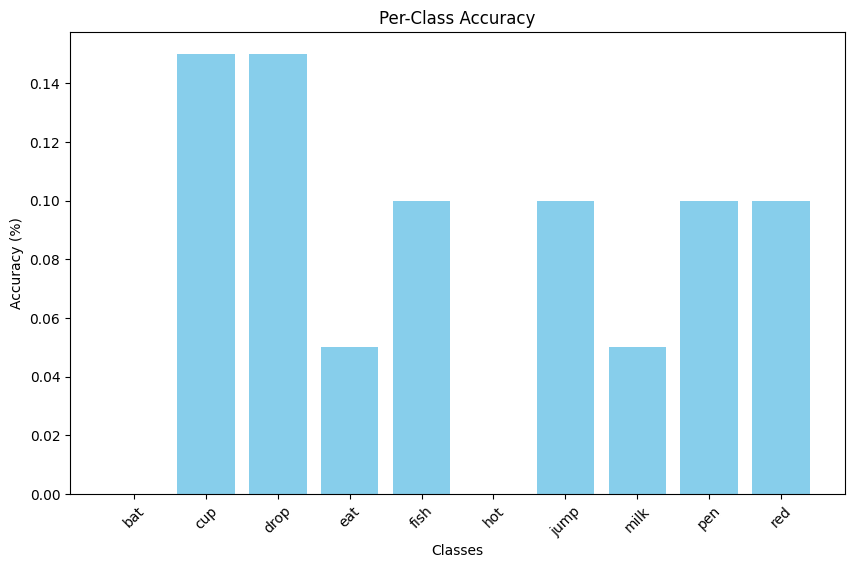

In [37]:
import matplotlib.pyplot as plt

# Plot Per-Class Accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_accuracies.keys(), class_accuracies.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.xticks(rotation=45)
plt.show()